# <font color=red> Melanoma Detection

## <font color=green>Bookmarks to Notebook Sections
 - [Importing all the important libraries](#import_libraries)
 - [Data Preparation](#data_preparation)
 - - [Train Data Set Creation](#train_data)
 - - [Validation Data Set Creation](#validation_data)
 - [Visualizing the Data](#visualize_data)
 - [Model 0 (with BatchNormalization layers)](#model_0)
 - - [Creating the Model](#creating_model_0)
 - - [Compiling the Model](#compiling_model_0)
 - - [Training the Model](#training_model_0)
 - - [Visualizing the Training Results](#visualize_results_0)
 - - [Observations](#observations_0)
 - [Model 1](#model_1)
 - - [Creating the Model](#creating_model_1)
 - - [Compiling the Model](#compiling_model_1)
 - - [Training the Model](#training_model_1)
 - - [Visualizing the Training Results](#visualize_results_1)
 - - [Observations](#observations_1)
 - [Data Augmentation](#Data_Augmentation)
 - - [Specifying the Augmentation](#specifying_augmentation)
 - - [Visualizing the Augmented Data](#visualizing_augmented_data)
 - [Model 2 (using Data Augmentation) ](#model_2)
 - - [Creating the Model](#creating_model_2)
 - - [Compiling the Model](#compiling_model_2)
 - - [Training the Model](#training_model_2)
 - - [Visualizing the Training Results](#visualize_results_2)
 - - [Observations](#observations_2)
 - [Checking for Class Imbalance](#Checking_for_Class_Imbalance)
 - [Using Augmentor for Class Imbalance Treatment](#Using_Augmentor_for_Class_Imbalance_Treatment)
 - - [Installing Augmentor](#Installing_augmentor)
 - - [Using Augmentor](#Using_augmentor)
 - - [Observations](#observations)
 - [Modelling Data using Augmentor](#modelling_data_using_augmentor)
 - - [Creating the Train Data Set](#creating_train_data_1)
 - - [Creating the Validation Data Set](#creating_validation_data_1)
 - [Model 3 (using class rebalance) ]((#model_3)
 - - [Creating the Model](#creating_model_3)
 - - [Compiling the Model](#compiling_model_3)
 - - [Training the Model](#training_model_3)
 - - [Visualizing the Training Results](#visualize_results_3)
 - - [Observations](#observations_3)

<h2><a id="import_libraries">1. Importing all the important libraries</a></h2>

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from IPython.display import Image,display,HTML

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This dataset has about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [31]:
# Defining the path for train and test images
trained_path="/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection_assignment_upgrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/"
tested_path="/content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection_assignment_upgrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Test/"
data_directory_train = pathlib.Path(trained_path)
data_directory_test = pathlib.Path(tested_path)

In [4]:
image_count_train = len(list(data_directory_train.glob('*/*.jpg')))
display(image_count_train)
image_count_test = len(list(data_directory_test.glob('*/*.jpg')))
display(image_count_test)

2239
118


<h2><a id="data_preparation">2. Data Preparation</a></h2>

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

<h3><a id="train_data">2.1 Train Data Set Creation</a></h3>

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


<h3><a id="validation_data">2.2 Validation Data Set Creation</a></h3>

In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
class_names = train_ds.class_names
display(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


<h2><a id="visualize_data">3. Visualizing the data </a></h2>

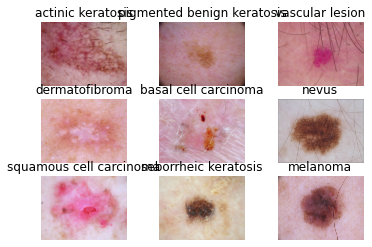

In [10]:
import matplotlib.pyplot as plt
num=0
for dirpath, dirnames, filenames in os.walk(str(trained_path)):
    for filename in [f for f in filenames if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(filename))
        plt.subplot(3,3,num+1)
        plt.title(str(dirpath).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        num=num+1

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

<h2><a id="model_0">4. Model 0 (with BatchNormalization layers)</a></h2>

<h3><a id="creating_model_0">4.1 Creating the model</a></h3>

In [12]:
model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])


<h3><a id="compiling_model_0">4.2 Compiling the model</a></h3>

In [13]:
### Selecting an appropriate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

<h3><a id="training_model_0">4.3 Training the model </a></h3>

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 756s 3s/step - loss: 3.1135 - accuracy: 0.1853 - val_loss: 2.0372 - val_accuracy: 0.2416
Epoch 2/20
56/56 [==============================] - 2s 40ms/step - loss: 1.9751 - accuracy: 0.2427 - val_loss: 1.9063 - val_accuracy: 0.3311
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.8062 - accuracy: 0.3382 - val_loss: 1.9453 - val_accuracy: 0.2975
Epoch 4/20
56/56 [==============================] - 2s 40ms/step - loss: 1.6307 - accuracy: 0.4169 - val_loss: 1.6492 - val_accuracy: 0.4586
Epoch 5/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5061 - accuracy: 0.4766 - val_loss: 1.7326 - val_accuracy: 0.3803
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 1.4712 - accuracy: 0.4771 - val_loss: 1.6806 - val_accuracy: 0.4183
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.3775 - accuracy: 0.5201 - val_loss: 1.4459 - val_accuracy: 0.5302
Epoch 8/20
56

In [15]:
# Viewing the summary of all layers
display(
    model.summary(),
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                    

<h3><a id="visualize_results_0">4.4 Visualizing training results </a></h3>

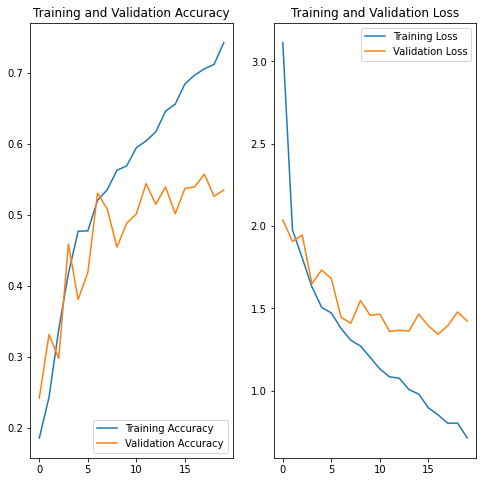

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
display(plt.show())

<h3><a id="observations_0">4.5 Observations </a></h3>

-  The accuracy of the model for the **Training data set** is at **78%**. But the **Validation accuracy** is not in par with the training accuracy. 
-  It is only at **53%**. The validation loss as observed is very high.
-  This could also be indicative of some **Overfit** in the model.
-  We could add some `Dropout` layers and remove the `BatchNormalization` layers. 
-  And by adding a few more layers, we could improve the accuracy by trying to extract more features.

<h2><a id="model_1">5. Model 1  </a></h2>

<h3><a id="creating_model_1">5.1 Creating the Model </a></h3>

In [17]:
model_update=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
                             
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

<h3><a id="compiling_model_1">5.2 Compiling the model  </a></h3>

In [18]:
model_update.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

<h3><a id="training_model_1">5.3 Training the model </a></h3>

In [19]:
epochs = 20
history = model_update.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 103ms/step - loss: 2.1213 - accuracy: 0.1825 - val_loss: 2.0433 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0373 - accuracy: 0.1853 - val_loss: 2.0319 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 5s 92ms/step - loss: 2.0286 - accuracy: 0.1875 - val_loss: 2.0403 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0349 - accuracy: 0.1881 - val_loss: 2.0240 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0285 - accuracy: 0.2015 - val_loss: 2.0203 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0183 - accuracy: 0.2254 - val_loss: 2.0244 - val_accuracy: 0.1924
Epoch 7/20
56/56 [==============================] - 5s 94ms/step - loss: 2.0197 - accuracy: 0.2199 - val_loss: 1.9851 - val_accuracy: 0.2953
Epoch 8/20
5

<h3><a id="visualize_results_1">5.4 Visualizing the results  </a></h3>

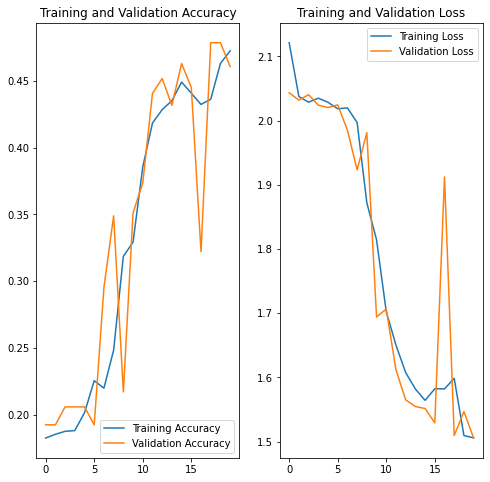

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
display(plt.show())

<h3><a id="observations_1">5.5 Observations </a></h3>

-  The model accuracy for **Train data set** has dropped to nearly **45%**.
-  The accuracy for the **Validation set** is at **40%**.
-  This is a much better model compared to the previous model as there seems to be **No Overfit** with the training accuracy **45%** and validation accuracy at **40%**.

<h2><a id="Data_Augmentation">6. Data Augmentation </a></h2>

<h3><a id="specifying_augmentation">6.1 Specifying the Augmentation</a></h3>

In [21]:
data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

<h3><a id="visualizing_augmented_data">6.2 Visualizing the Augmented Data</a></h3>

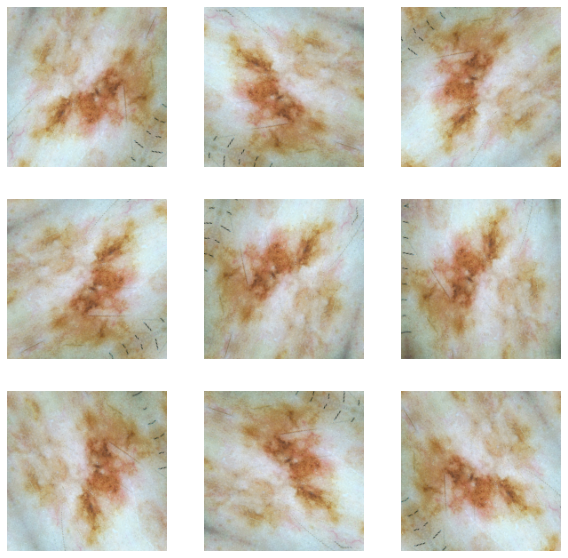

In [22]:
image, label = next(iter(train_ds))
image=np.array(image,np.int32)  
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)  
  plt.imshow((augmented_image1))
  plt.axis("off")

<h2><a id="model_2">7. Model 2 (using Data Augmentation) </a></h2>

<h3><a id="creating_model_2">7.1 Creating the Model </a></h3>

In [23]:
model_augmented=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

<h3><a id="compiling_model_2">7.2 Compiling the model </a></h3>

In [24]:
model_augmented.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

<h3><a id="training_model_2">7.3 Training the model </a></h3>

In [25]:
epochs = 20
history = model_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 116ms/step - loss: 2.1915 - accuracy: 0.1752 - val_loss: 2.0506 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 6s 112ms/step - loss: 2.0300 - accuracy: 0.1875 - val_loss: 1.9952 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 6s 112ms/step - loss: 1.9085 - accuracy: 0.2969 - val_loss: 1.7929 - val_accuracy: 0.3758
Epoch 4/20
56/56 [==============================] - 6s 112ms/step - loss: 1.7590 - accuracy: 0.3700 - val_loss: 1.7534 - val_accuracy: 0.3758
Epoch 5/20
56/56 [==============================] - 6s 112ms/step - loss: 1.7053 - accuracy: 0.3828 - val_loss: 1.6465 - val_accuracy: 0.3848
Epoch 6/20
56/56 [==============================] - 6s 113ms/step - loss: 1.6609 - accuracy: 0.3912 - val_loss: 1.8836 - val_accuracy: 0.3020
Epoch 7/20
56/56 [==============================] - 6s 113ms/step - loss: 1.6238 - accuracy: 0.3990 - val_loss: 1.6028 - val_accuracy: 0.4139
Epoch 

<h3><a id="visualize_results_2">7.4 Visualizing the results  </a></h3>

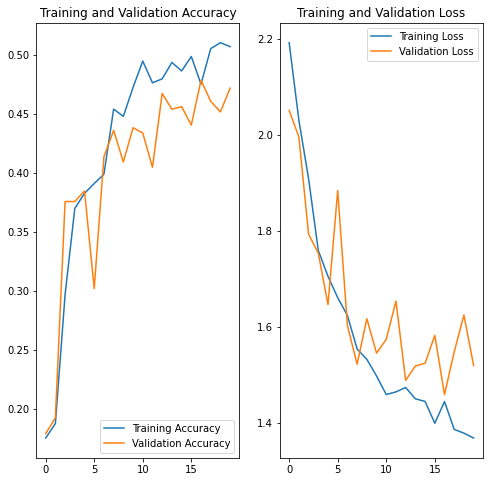

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
display(plt.show())

<h3><a id="observations_2">7.5  Observations </a></h3>

-  The model accuracy for **Train data set** has gone up to nearly **48%**.
-  The accuracy for the **Validation set** is also at **48%**.
-  This is a much better model compared to the previous two models as there seems to be **No Overfit** with the training accuracy **48%** and validation accuracy at **48%**.
-  `Data Augmentation` has improved the model performance.

<h2><a id="Checking_for_Class_Imbalance">8. Checking for Class Imbalance </a></h2>

In [27]:
for i in class_names:
    directory =trained_path+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    display(f'{i} has {length} samples.')

actinic keratosis has 0 samples.
basal cell carcinoma has 0 samples.
dermatofibroma has 0 samples.
melanoma has 0 samples.
nevus has 0 samples.
pigmented benign keratosis has 0 samples.
seborrheic keratosis has 0 samples.
squamous cell carcinoma has 0 samples.
vascular lesion has 0 samples.


-  The samples of various classes are not in equal proportion.
-  There is a significant **Class Imbalance** observed.
-  The class with the least number of samples is `Seborrheic Keratosis` with **77**.
-  The class that dominates the data in terms of proportionate number of samples is `Pigmented Benign Keratosis` with sample size of **462**. 

<h2><a id="Using_Augmentor_for_Class_Imbalance_Treatment">9. Using Augmentor for Class Imbalance Treatment</a></h2>

<h3><a id="Installing_augmentor">9.1 Installing Augmentor</a></h3>

In [29]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


<h3><a id="Using_augmentor">9.2 Using Augmentor </a></h3>

In [32]:
path_to_training_dataset=trained_path
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection_assignment_upgrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5E0CCE3970>: 100%|██████████| 500/500 [00:18<00:00, 27.70 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection_assignment_upgrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5E0CC7B1C0>: 100%|██████████| 500/500 [00:17<00:00, 28.28 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection_assignment_upgrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5E0CA5FDF0>: 100%|██████████| 500/500 [00:17<00:00, 28.05 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection_assignment_upgrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F5E0CA341C0>: 100%|██████████| 500/500 [01:25<00:00,  5.87 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection_assignment_upgrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5E0C954610>: 100%|██████████| 500/500 [01:14<00:00,  6.70 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection_assignment_upgrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5E0CA55E20>: 100%|██████████| 500/500 [00:17<00:00, 28.02 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection_assignment_upgrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5E0E13C100>: 100%|██████████| 500/500 [00:43<00:00, 11.48 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection_assignment_upgrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5E0C967D30>: 100%|██████████| 500/500 [00:17<00:00, 28.26 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_Notebooks/Melanoma_detection_assignment_upgrad/Skin_cancer_ISIC_The_International_Skin_Imaging_Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5E0C968610>: 100%|██████████| 500/500 [00:17<00:00, 27.97 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_directory_train.glob('*/output/*.jpg')))
display(image_count_train)

4500


In [34]:
path_list = [x for x in glob(os.path.join(data_directory_train, '*','output', '*.jpg'))]

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_directory_train, '*','output', '*.jpg'))]

In [36]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [37]:
for i in class_names:
    directory =trained_path+i+'/'
    directory_out =trained_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    display(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


<h3><a id="observations">9.3 Observations </a></h3>

-  The Augmentor has **helped decrease the imbalance** in class images and that can be viewed from above.

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

<h2><a id="modelling_data_using_augmentor">10. Modelling Augmented Data</a></h2>

In [38]:
batch_size = 32
img_height = 180
img_width = 180

<h3><a id="creating_train_data_1">10.1 Creating the Train Data Set</a></h3>

In [39]:
data_directory_train=trained_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_directory_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


<h3><a id="creating_validation_data_1">10.2 Creating the Validation Data Set</a></h3>

In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_directory_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


<h2><a id="model_3">11. Model 3 (using class rebalance) </a></h2>

<h3><a id="creating_model_3">11.1 Creating the Model</a></h3>

In [41]:
model_final=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

<h3><a id="compiling_model_3">11.2 Compiling the Model </a></h3>

In [42]:
model_final.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

<h3><a id="training_model_3">11.3 Training the Model </a></h3>

In [43]:
epochs = 30

history = model_final.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 34s 191ms/step - loss: 2.6617 - accuracy: 0.1569 - val_loss: 2.0204 - val_accuracy: 0.3177
Epoch 2/30
169/169 [==============================] - 32s 184ms/step - loss: 1.8319 - accuracy: 0.3118 - val_loss: 1.8401 - val_accuracy: 0.3022
Epoch 3/30
169/169 [==============================] - 32s 182ms/step - loss: 1.5672 - accuracy: 0.4045 - val_loss: 1.4131 - val_accuracy: 0.4566
Epoch 4/30
169/169 [==============================] - 33s 189ms/step - loss: 1.4439 - accuracy: 0.4620 - val_loss: 1.5059 - val_accuracy: 0.4291
Epoch 5/30
169/169 [==============================] - 32s 182ms/step - loss: 1.3140 - accuracy: 0.5030 - val_loss: 1.2563 - val_accuracy: 0.5234
Epoch 6/30
169/169 [==============================] - 32s 181ms/step - loss: 1.2259 - accuracy: 0.5378 - val_loss: 1.1394 - val_accuracy: 0.5679
Epoch 7/30
169/169 [==============================] - 32s 181ms/step - loss: 1.1080 - accuracy: 0.5966 - val_loss: 1.1079 - val_ac

<h3><a id="visualize_results_3">11.4 Visualizing the model results </a></h3>

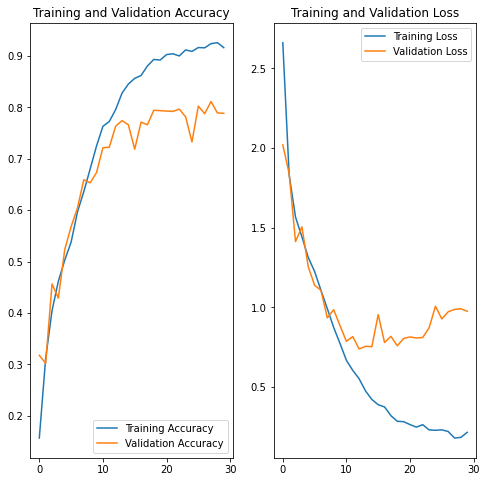

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
display(plt.show())

<h3><a id="observations_3">11.5 Observations</a></h3>

-  The training accuracy seems to be nearly **~90%**. 
-  The validation accuracy is nearly **~80%**.
-  Though the model accuracy has improved, the **class rebalance** has helped **treat the overfitting to some extent**.
-  Much better models could be built or tried out using **more epochs and more layers**.